In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210611'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '오피스텔'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:00, 31.66it/s]


(180972, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(178537, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '금천구'
target_dong = '독산동'
target_purpose = '준공업'
target_building_age = 5
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(896, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
164176,서울특별시 금천구 독산동 145-7,시흥대로141길 72,성지채움빌,32.50,22000,2,2016.0,3.0,2019-11-28,676.923077,5.0,오피스텔,대,408.6,준공업지역,지정되지않음,상업기타,평지,세로장방,소로한면,금천구,독산동
167554,서울특별시 금천구 독산동 974-1,문성로 2,(974-1),49.48,23500,5,2017.0,4.0,2021-02-22,474.939369,4.0,오피스텔,대,653.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,금천구,독산동
167556,서울특별시 금천구 독산동 1012-12,시흥대로116길 9,SD 아크로타워,29.59,19000,7,2017.0,3.0,2020-12-10,642.108821,4.0,오피스텔,대,455.7,근린상업지역,지정되지않음,주상용,평지,가로장방,소로한면,금천구,독산동
167557,서울특별시 금천구 독산동 1012-12,시흥대로116길 9,SD 아크로타워,33.95,18250,4,2017.0,4.0,2021-04-15,537.555228,4.0,오피스텔,대,455.7,근린상업지역,지정되지않음,주상용,평지,가로장방,소로한면,금천구,독산동
167558,서울특별시 금천구 독산동 1012-12,시흥대로116길 9,SD 아크로타워,29.59,18250,5,2017.0,4.0,2021-04-15,616.762420,4.0,오피스텔,대,455.7,근린상업지역,지정되지않음,주상용,평지,가로장방,소로한면,금천구,독산동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(896, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
164176,서울특별시 금천구 독산동 145-7,시흥대로141길 72,성지채움빌,32.50,22000,2,2016.0,3.0,2019-11-28,676.923077,5.0,오피스텔,대,408.6,준공업지역,지정되지않음,상업기타,평지,세로장방,소로한면,금천구,독산동,760.185433,2021-03-01
167554,서울특별시 금천구 독산동 974-1,문성로 2,(974-1),49.48,23500,5,2017.0,4.0,2021-02-22,474.939369,4.0,오피스텔,대,653.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,금천구,독산동,480.173409,2021-03-01
167556,서울특별시 금천구 독산동 1012-12,시흥대로116길 9,SD 아크로타워,29.59,19000,7,2017.0,3.0,2020-12-10,642.108821,4.0,오피스텔,대,455.7,근린상업지역,지정되지않음,주상용,평지,가로장방,소로한면,금천구,독산동,655.495446,2021-03-01
167557,서울특별시 금천구 독산동 1012-12,시흥대로116길 9,SD 아크로타워,33.95,18250,4,2017.0,4.0,2021-04-15,537.555228,4.0,오피스텔,대,455.7,근린상업지역,지정되지않음,주상용,평지,가로장방,소로한면,금천구,독산동,537.555228,2021-04-15
167558,서울특별시 금천구 독산동 1012-12,시흥대로116길 9,SD 아크로타워,29.59,18250,5,2017.0,4.0,2021-04-15,616.762420,4.0,오피스텔,대,455.7,근린상업지역,지정되지않음,주상용,평지,가로장방,소로한면,금천구,독산동,616.762420,2021-04-15


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 금천구 독산동 1005-3,1동,0.0,29.92,2021-02-05,24700,825.534759,2021-03-01,834.632514,준공업지역,오피스텔
1,서울특별시 금천구 독산동 1005-3,1동,0.0,29.92,2021-02-05,24700,825.534759,2021-03-01,834.632514,준공업지역,오피스텔
2,서울특별시 금천구 독산동 1005-3,1동,0.0,29.93,2021-02-05,24700,825.258938,2021-03-01,834.353652,준공업지역,오피스텔
3,서울특별시 금천구 독산동 1005-3,1동,0.0,29.93,2021-02-05,24700,825.258938,2021-03-01,834.353652,준공업지역,오피스텔
4,서울특별시 금천구 독산동 1005-3,1동,0.0,29.92,2021-02-05,24700,825.534759,2021-03-01,834.632514,준공업지역,오피스텔


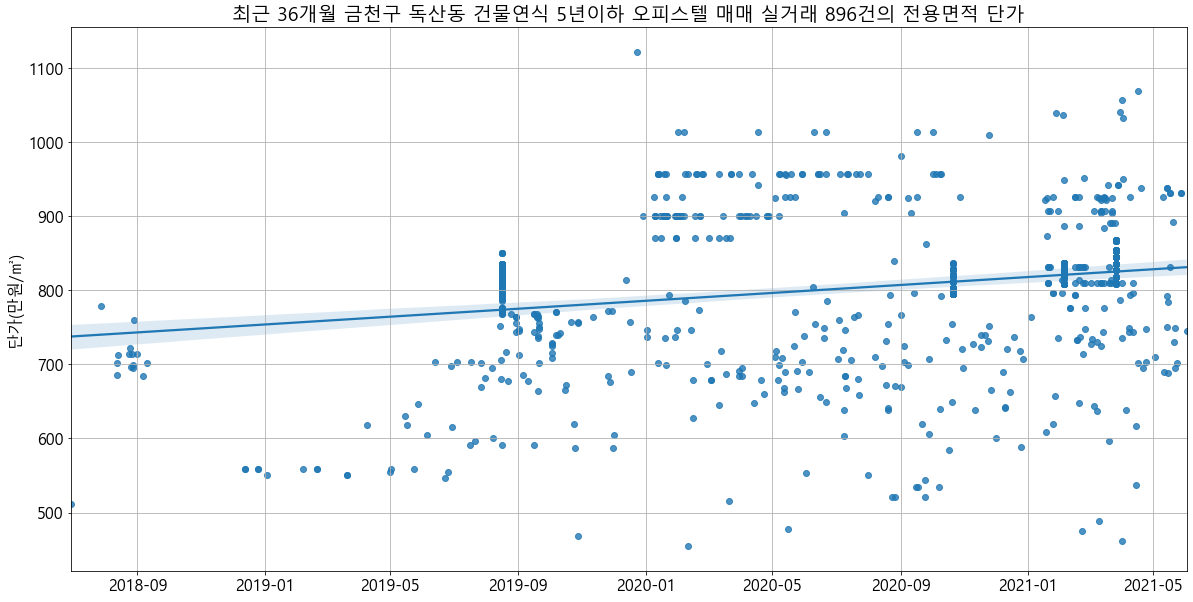

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

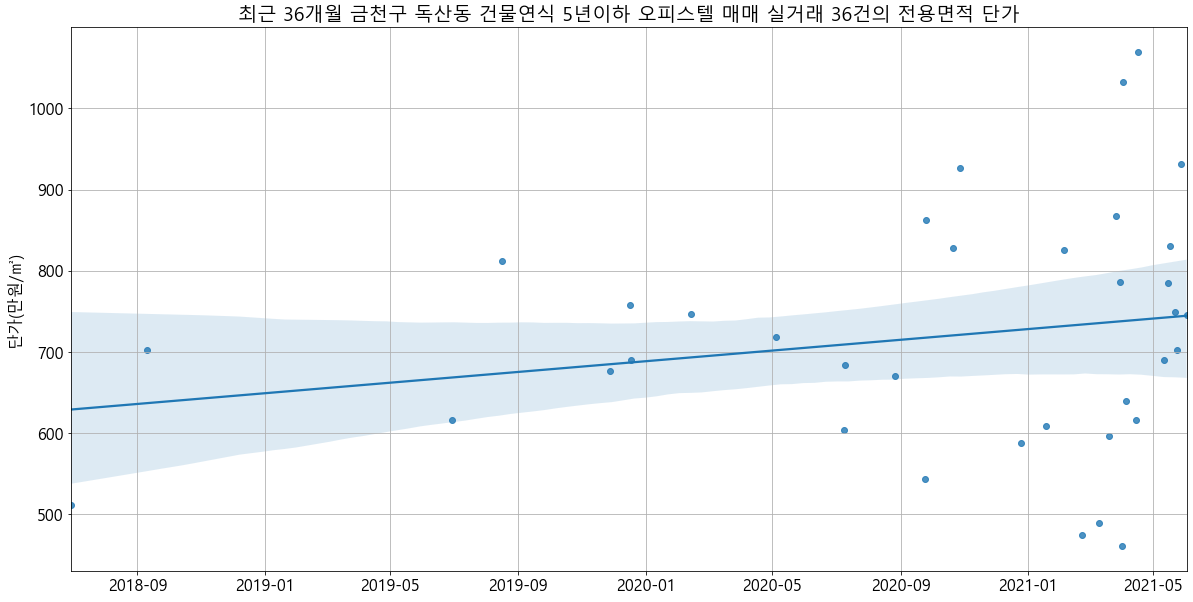

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1115, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
39735,서울특별시 금천구 독산동 303-1,가산로3길 77,독산동주상복합,28.02,6000,3,2001.0,5.0,2006-09-27,214.132762,20.0,오피스텔,대,1381.9,준공업지역,지정되지않음,상업기타,평지,가로장방,소로각지,금천구,독산동
39736,서울특별시 금천구 독산동 303-1,가산로3길 77,독산동주상복합,57.90,7500,3,2001.0,5.0,2006-10-11,129.533679,20.0,오피스텔,대,1381.9,준공업지역,지정되지않음,상업기타,평지,가로장방,소로각지,금천구,독산동
39768,서울특별시 금천구 독산동 289-12,두산로 79,메이씨티 오피스텔,55.77,19500,3,2005.0,1.0,2006-03-31,349.650350,16.0,오피스텔,주유소용지,1111.2,준공업지역,지정되지않음,상업용,평지,사다리형,중로한면,금천구,독산동
39769,서울특별시 금천구 독산동 289-12,두산로 79,메이씨티 오피스텔,55.77,16000,11,2005.0,2.0,2007-07-20,286.892595,16.0,오피스텔,주유소용지,1111.2,준공업지역,지정되지않음,상업용,평지,사다리형,중로한면,금천구,독산동
39770,서울특별시 금천구 독산동 289-12,두산로 79,메이씨티 오피스텔,53.19,16000,11,2005.0,2.0,2007-07-24,300.808423,16.0,오피스텔,주유소용지,1111.2,준공업지역,지정되지않음,상업용,평지,사다리형,중로한면,금천구,독산동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'금천구 독산동 계약날짜기준 건물연식 5년이하 오피스텔 매매 실거래 1115건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

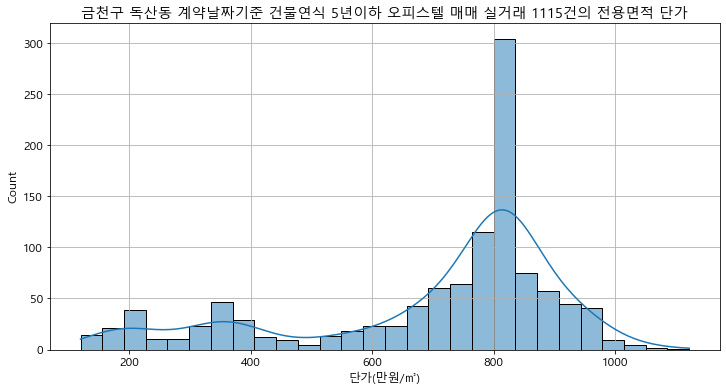

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(135, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 금천구 독산동 1005-3,범안로12길 50,1동,29.92,24700,6,2021.0,0.0,2021-02-05,825.534759,0.0,오피스텔,대,1006.4,준공업지역,지정되지않음,공업기타,완경사,사다리형,소로한면,금천구,독산동,834.632514,2021-03-01,825.396848,834.493083
1,서울특별시 금천구 독산동 1005-3,범안로12길 50,1동,29.93,24700,6,2021.0,0.0,2021-02-05,825.258938,0.0,오피스텔,대,1006.4,준공업지역,지정되지않음,공업기타,완경사,사다리형,소로한면,금천구,독산동,834.353652,2021-03-01,825.396848,834.493083
2,서울특별시 금천구 독산동 1006-115,범안로12길 29-25,중앙하이빌,28.71,18700,2,2016.0,1.0,2017-01-23,651.340996,5.0,오피스텔,대,440.5,준공업지역,지정되지않음,다세대,평지,세로장방,세로한면(가),금천구,독산동,853.250382,2021-03-01,593.037596,776.873494
3,서울특별시 금천구 독산동 1006-115,범안로12길 29-25,중앙하이빌,41.00,26700,2,2016.0,1.0,2017-01-23,651.219512,5.0,오피스텔,대,440.5,준공업지역,지정되지않음,다세대,평지,세로장방,세로한면(가),금천구,독산동,853.091239,2021-03-01,593.037596,776.873494
4,서울특별시 금천구 독산동 1006-115,범안로12길 29-25,중앙하이빌,52.69,28200,2,2016.0,1.0,2017-01-23,535.205921,5.0,오피스텔,대,440.5,준공업지역,지정되지않음,다세대,평지,세로장방,세로한면(가),금천구,독산동,701.114562,2021-03-01,593.037596,776.873494


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(50, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
1,서울특별시 금천구 독산동 1005-3,범안로12길 50,1동,29.93,24700,6,2021.0,0.0,2021-02-05,825.258938,0.0,오피스텔,대,1006.4,준공업지역,지정되지않음,공업기타,완경사,사다리형,소로한면,금천구,독산동,834.353652,2021-03-01,825.396848,834.493083
5,서울특별시 금천구 독산동 1006-115,범안로12길 29-25,중앙하이빌,69.80,37300,2,2016.0,1.0,2017-01-23,534.383954,5.0,오피스텔,대,440.5,준공업지역,지정되지않음,다세대,평지,세로장방,세로한면(가),금천구,독산동,700.037792,2021-03-01,593.037596,776.873494
6,서울특별시 금천구 독산동 1006-118,범안로12가길 32,빌인사이드파크1,39.98,17000,2,2016.0,1.0,2017-07-26,425.212606,5.0,오피스텔,대,108.9,준공업지역,지정되지않음,다세대,평지,사다리형,세로한면(가),금천구,독산동,533.459362,2021-03-01,425.212606,533.459362
10,서울특별시 금천구 독산동 1006-3,범안로12가길 7,미림A클래스,25.91,18000,4,2018.0,0.0,2018-08-28,694.712466,3.0,오피스텔,대,737.2,준공업지역,지정되지않음,공업기타,평지,세로장방,세로한면(가),금천구,독산동,826.324107,2021-03-01,719.836893,854.365768
11,서울특별시 금천구 독산동 1006-49,범안로14길 9-12,\t(1006-49)\t,52.76,19600,5,2014.0,1.0,2015-05-24,371.493556,7.0,오피스텔,대,372.0,준공업지역,지정되지않음,주거기타,평지,사다리형,세로한면(가),금천구,독산동,526.311893,2021-03-01,371.493556,526.311893
12,서울특별시 금천구 독산동 1006-64,범안로12가길 31-16,현대힐타운,38.13,30000,3,2016.0,5.0,2021-03-30,786.782061,5.0,오피스텔,대,201.1,준공업지역,지정되지않음,다세대,평지,부정형,세로각지(가),금천구,독산동,786.782061,2021-03-30,786.782061,786.782061
16,서울특별시 금천구 독산동 1006-91,범안로16길 40,예지다움91차,71.06,38000,2,2020.0,0.0,2020-10-08,534.759358,1.0,오피스텔,대,329.7,준공업지역,지정되지않음,주상용,완경사,사다리형,세로각지(가),금천구,독산동,563.817044,2021-03-01,618.631937,647.798743
20,서울특별시 금천구 독산동 1007-13,범안로 1212,e편한세상 독산 더타워,26.51,20800,32,2019.0,2.0,2021-05-15,784.609581,2.0,오피스텔,대,7841.4,일반상업지역,지정되지않음,상업기타,평지,세로장방,중로각지,금천구,독산동,784.609581,2021-05-15,757.285770,791.197369
21,서울특별시 금천구 독산동 1009-61,시흥대로101길 20,팔레스타운,59.73,27200,2,2017.0,1.0,2018-02-09,455.382555,4.0,오피스텔,대,306.2,준공업지역,지정되지않음,주상용,완경사,사다리형,세로각지(가),금천구,독산동,564.771931,2021-03-01,455.382555,564.771931
23,서울특별시 금천구 독산동 1011-2,시흥대로101길 11,정우펠리스,48.32,36000,2,2018.0,3.0,2021-06-02,745.033113,3.0,오피스텔,대,561.7,준공업지역,지정되지않음,주상용,완경사,사다리형,세로한면(가),금천구,독산동,745.033113,2021-06-02,693.029377,699.711398


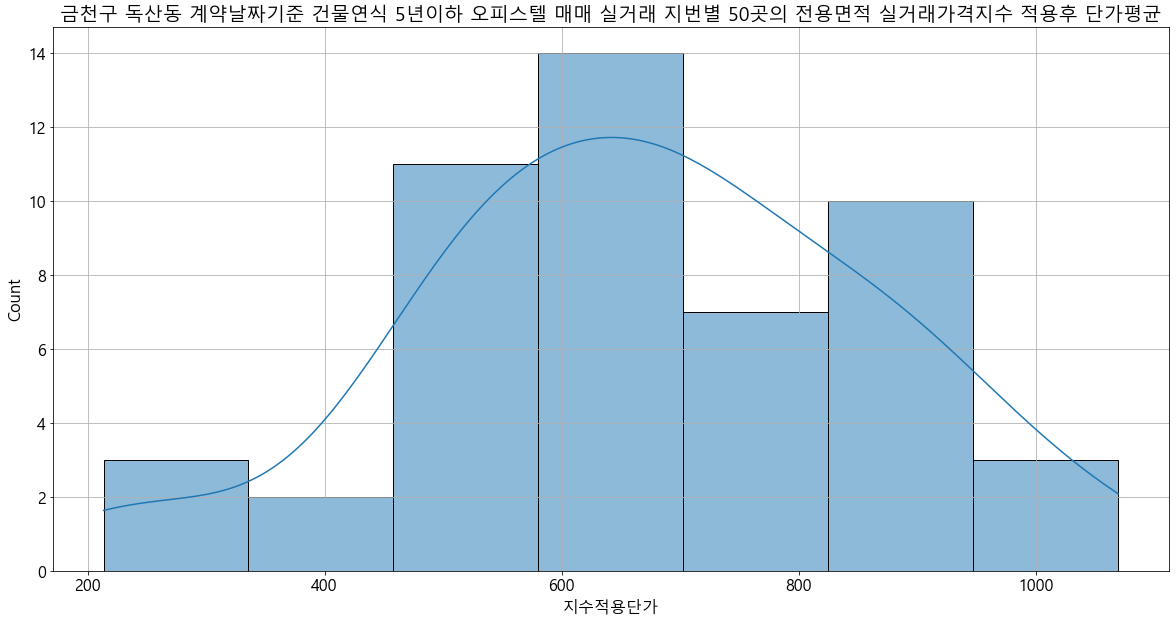

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 금천구 독산동 1005-3,1동,2021.0,29.93,2021-02-05,825.258938,2021-03-01,834.353652,준공업지역,오피스텔
1,서울특별시 금천구 독산동 1006-115,중앙하이빌,2016.0,69.80,2017-01-23,534.383954,2021-03-01,700.037792,준공업지역,오피스텔
2,서울특별시 금천구 독산동 1006-118,빌인사이드파크1,2016.0,39.98,2017-07-26,425.212606,2021-03-01,533.459362,준공업지역,오피스텔
3,서울특별시 금천구 독산동 1006-3,미림A클래스,2018.0,25.91,2018-08-28,694.712466,2021-03-01,826.324107,준공업지역,오피스텔
4,서울특별시 금천구 독산동 1006-49,\t(1006-49)\t,2014.0,52.76,2015-05-24,371.493556,2021-03-01,526.311893,준공업지역,오피스텔


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)